In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf


In [3]:
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:90%]', 'train[90%:]', 'test[:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


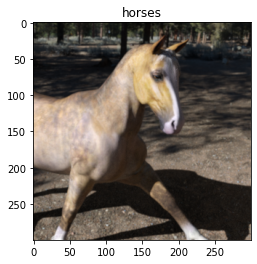

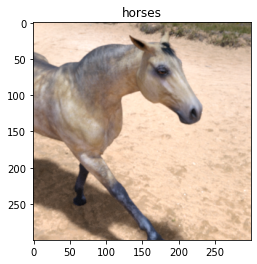

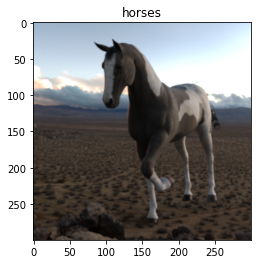

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(3):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 224 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
#   image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

image.shape

TensorShape([300, 300, 3])

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
validation_batches = validation_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

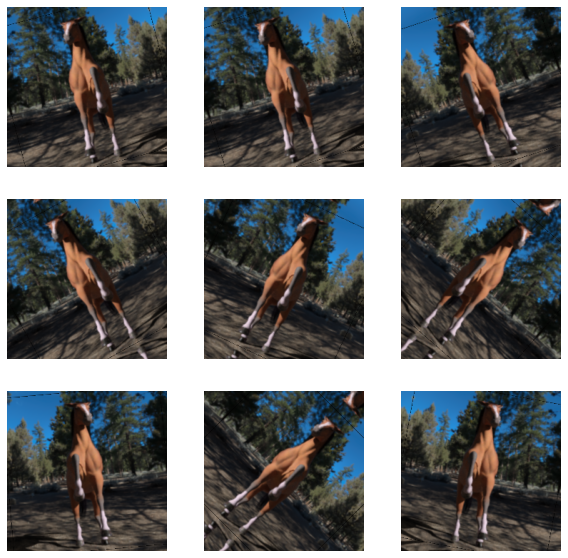

In [13]:
for image, _ in train_batches.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [16]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  155


In [18]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [19]:
base_model.trainable = False

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dropout = tf.keras.layers.Dropout(0.5)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(test_batches)

8/8 [==============================] - 2s 227ms/step - loss: 0.3803 - accuracy: 0.8359


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.38
initial accuracy: 0.84


In [29]:
history = model.fit(train_batches, epochs=initial_epochs,validation_data=validation_batches)

Epoch 1/10
29/29 [==============================] - 9s 319ms/step - loss: 0.5325 - accuracy: 0.7251 - val_loss: 0.3859 - val_accuracy: 0.7767
Epoch 2/10
29/29 [==============================] - 9s 312ms/step - loss: 0.4458 - accuracy: 0.7890 - val_loss: 0.3330 - val_accuracy: 0.8155
Epoch 3/10
29/29 [==============================] - 9s 305ms/step - loss: 0.3918 - accuracy: 0.8214 - val_loss: 0.2997 - val_accuracy: 0.8155
Epoch 4/10
29/29 [==============================] - 9s 306ms/step - loss: 0.3263 - accuracy: 0.8474 - val_loss: 0.2640 - val_accuracy: 0.8641
Epoch 5/10
29/29 [==============================] - 9s 313ms/step - loss: 0.3021 - accuracy: 0.8680 - val_loss: 0.2339 - val_accuracy: 0.8641
Epoch 6/10
29/29 [==============================] - 10s 330ms/step - loss: 0.2707 - accuracy: 0.8820 - val_loss: 0.2095 - val_accuracy: 0.9126
Epoch 7/10
29/29 [==============================] - 9s 327ms/step - loss: 0.2328 - accuracy: 0.9048 - val_loss: 0.1887 - val_accuracy: 0.9126
Epoch

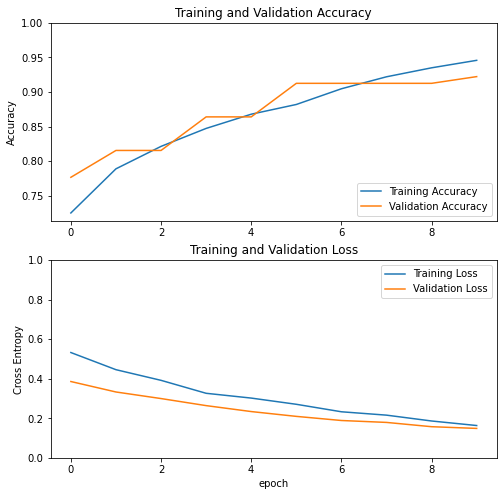

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
base_model.trainable = True


In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [35]:
len(model.trainable_variables)


58

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
29/29 [==============================] - 14s 475ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 1.9266e-04 - val_accuracy: 1.0000
Epoch 11/20
29/29 [==============================] - 14s 469ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 1.5382e-04 - val_accuracy: 1.0000
Epoch 12/20
29/29 [==============================] - 14s 469ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2690e-04 - val_accuracy: 1.0000
Epoch 13/20
29/29 [==============================] - 13s 462ms/step - loss: 2.0943e-04 - accuracy: 1.0000 - val_loss: 1.4705e-04 - val_accuracy: 1.0000
Epoch 14/20
29/29 [==============================] - 13s 457ms/step - loss: 0.0018 - accuracy: 0.9989 - val_loss: 7.8891e-05 - val_accuracy: 1.0000
Epoch 15/20
29/29 [==============================] - 14s 474ms/step - loss: 8.0769e-04 - accuracy: 1.0000 - val_loss: 1.2959e-04 - val_accuracy: 1.0000
Epoch 16/20
29/29 [==============================] - 14s 475ms/step - loss: 3.1241e-04 - accuracy: 1.000

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

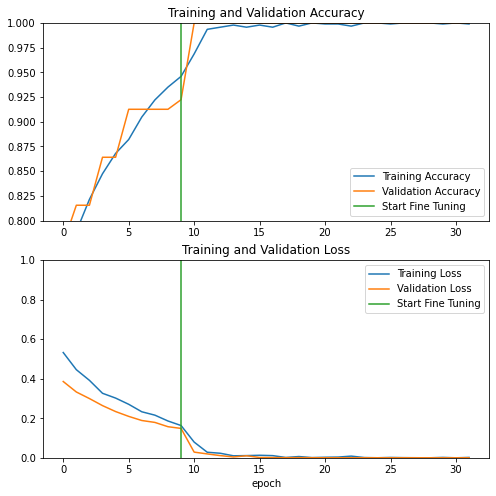

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)


Predictions:
 [0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1]
Labels:
 [0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1]


In [48]:
history_test = model.evaluate(image_batch,label_batch)

1/1 [==============================] - 0s 703us/step - loss: 9.2958e-04 - accuracy: 1.0000


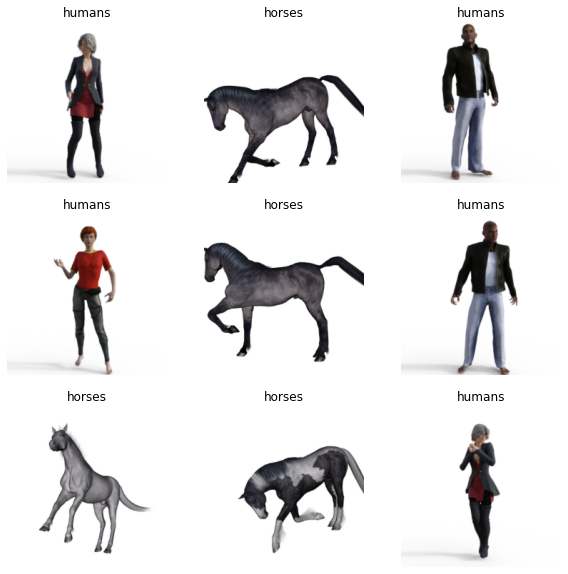

In [49]:

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i+9].astype("uint8"))
  plt.title(get_label_name(predictions[i+9]))

  plt.axis("off")